# COVID-19 Worldwide report analysis

Utilizes the daily data reporting from Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE):
https://systems.jhu.edu/. This is pulled from time series maintained at Github repo:
https://github.com/CSSEGISandData/COVID-19.  

Using the introductory Data Science Tables (for reference see http://data8.org/datascience/tables.html) of introductory courses.

On 3/23 the timeseries moved and US state level data is no longer present.

In [1]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [2]:
import sys
sys.path.append(".")
from timetable import TimeTable

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

import os
import datetime

# Parsing and cleaning
def denan(v):
    return v if v != 'nan' else np.nan

def clean(tbl):
    for lbl in tbl.labels:
        tbl[lbl] = tbl.apply(denan, lbl)

def is_state(name):
    return not ',' in name
def is_county(name):
    return ',' in name
def getstate(name):
    county, state = name.split(', ')
    return state
def getcounty(name):
    county, state = name.split(', ')
    return county

# Tools for working with timestamps
def less_day(day1, day2):
    """Return day1 < day2"""
    return datetime.datetime.strptime(day1, "%m/%d/%y") < datetime.datetime.strptime(day2, "%m/%d/%y")

# Projecting growth rates

def ave_growth(trend, window=4):
    """Average recent growth rate of single trend"""
    return np.mean(trend.take[-window:]['rate'])

def inc_day(day, ndays=1):
    """Return day + ndays"""
    date =  datetime.datetime.strptime(day, "%m/%d/%y") + datetime.timedelta(days=ndays)
    return datetime.datetime.strftime(date, "%m/%d/%y")

def project_trend(trend, num_days, rate=None):
    if rate :
        growth_rate = rate
    else :
        growth_rate = ave_growth(trend)
        
    day = trend.last('Day')
    val = trend.last(1)
    growth = trend.last('new')
    pnew = trend.last('% new')
    proj = trend.copy()
    for i in range(num_days):
        day = inc_day(day)
        growth = round(growth * growth_rate)
        val = val + growth
        pnew = growth/val
        proj.append((day, val, growth, pnew, growth_rate))
    return proj

In [3]:
# Tools for working with content
def by_country(raw_world):
    """Aggregate country level data from the raw source"""
    res = raw_world.drop(['Province/State', 'Lat', 'Long']).group('Country/Region', sum)
    for lbl in res.labels[1:] :
        res.relabel(lbl, lbl[:-4])
    return res

In [4]:
# CSV files for data currated by JHU.
#confirmedURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
confirmedURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" 

#deathURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
#recoveredURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"

In [5]:
# Raw data of confirmed cases
raw_confirmed = Table.read_table(confirmedURL)
raw_confirmed

Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
nan,Afghanistan,33,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40
nan,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104
nan,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230
nan,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133
nan,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3
nan,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,3
nan,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,8,12,12,17,19,19,31,34,45,56,68,79,97,128,158,266,301
nan,Armenia,40.0691,45.0382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,4,8,18,26,52,78,84,115,136,160,194,235
Australian Capital Territory,Australia,-35.4735,149.012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,3,4,6,9,19,32
New South Wales,Australia,-33.8688,151.209,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,6,13,22,22,26,28,38,48,55,65,65,92,112,134,171,210,267,307,353,436,669,669


In [6]:
# Aggregate data by country

raw_by_country = by_country(raw_confirmed)

### How many of the 195 recognized countries in the world have reported cases?

This does include some non-countries, like Princess Cruises

In [7]:
raw_by_country.num_rows

168

In [8]:
# Transpose country data to provide timeseries column per country

countries_by_day = TimeTable.transpose(raw_by_country, 'Country/Region', time_less = less_day)
#countries_by_day.take[-7:]

In [9]:
# Change this to truncate data analysys to an earlier date
last_day = countries_by_day.last('Day')
print("last day of data:", last_day)
#last_day = "3/22/20"
countries_by_day = countries_by_day.until(last_day)
countries_by_day.order_cols().take[-10:]

last day of data: 3/23/20


Day,China,Italy,US,Spain,Germany,Iran,France,"Korea, South",Switzerland,United Kingdom,Netherlands,Austria,Belgium,Norway,Canada,Portugal,Sweden,Brazil,Australia,Denmark,Turkey,Malaysia,Israel,Czechia,Japan,Ireland,Ecuador,Luxembourg,Pakistan,Poland,Chile,Thailand,Cruise Ship,Finland,Greece,Iceland,Indonesia,Romania,Saudi Arabia,Singapore,Qatar,India,Philippines,Slovenia,Russia,South Africa,Peru,Bahrain,Egypt,Estonia,Panama,Mexico,Croatia,Argentina,Colombia,Lebanon,Iraq,Serbia,Dominican Republic,Armenia,Algeria,Bulgaria,United Arab Emirates,Taiwan*,Kuwait,San Marino,Slovakia,Latvia,Lithuania,Hungary,Uruguay,Costa Rica,Morocco,Bosnia and Herzegovina,North Macedonia,Andorra,Jordan,Vietnam,Cyprus,Moldova,Malta,Albania,New Zealand,Burkina Faso,Sri Lanka,Brunei,Tunisia,Cambodia,Belarus,Senegal,Venezuela,Ukraine,Azerbaijan,Oman,Kazakhstan,Georgia,Cameroon,Liechtenstein,Trinidad and Tobago,Uzbekistan,Afghanistan,Cuba,Nigeria,Congo (Kinshasa),Mauritius,Rwanda,Bangladesh,Honduras,Bolivia,Ghana,Montenegro,Cote d'Ivoire,Monaco,Paraguay,Guatemala,Guyana,Jamaica,Togo,Barbados,Kenya,Kyrgyzstan,Maldives,Madagascar,Tanzania,Ethiopia,Mongolia,Equatorial Guinea,Uganda,Seychelles,Haiti,Benin,Gabon,Suriname,Bahamas,Congo (Brazzaville),Eswatini,Guinea,Namibia,Angola,Antigua and Barbuda,Cabo Verde,Central African Republic,Djibouti,El Salvador,Fiji,Liberia,Niger,Saint Lucia,Zambia,Zimbabwe,Bhutan,Dominica,Gambia,Mauritania,Nepal,Nicaragua,Sudan,Belize,Chad,Eritrea,Grenada,Holy See,Mozambique,Papua New Guinea,Saint Vincent and the Grenadines,Somalia,Syria,Timor-Leste
3/14/20,80977,21157,2727,6391,4585,12729,4496,8086,1359,1144,962,655,689,1090,198,169,961,151,250,836,5,238,193,189,773,129,28,51,31,103,61,82,706,225,228,156,96,123,103,212,337,102,111,181,59,38,38,210,109,115,36,26,38,34,22,93,110,46,11,18,37,41,85,53,104,80,44,26,8,30,4,26,17,18,14,1,1,53,26,12,18,38,6,2,10,40,18,7,27,10,2,3,15,19,6,30,2,4,2,0,11,4,2,2,0,1,3,2,10,3,0,1,2,6,1,1,8,1,0,1,0,10,0,0,1,1,0,0,2,0,0,1,1,0,0,1,1,2,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0
3/15/20,81003,24747,3499,7798,5795,13938,4532,8162,2200,1145,1138,860,886,1221,252,245,1022,162,297,875,6,428,251,253,839,129,28,59,53,119,74,114,706,244,331,171,117,131,103,226,401,113,140,219,63,51,43,214,110,171,43,41,49,45,34,110,116,48,11,26,48,51,98,59,112,101,54,30,12,32,4,27,28,24,14,1,8,56,26,23,21,42,8,3,18,50,18,7,27,24,10,3,23,22,9,33,2,4,2,1,16,4,2,2,0,1,5,3,10,6,0,1,2,6,1,4,10,1,0,3,0,13,0,0,1,1,1,0,2,0,0,1,1,0,1,1,1,2,0,1,0,1,0,0,0,0,0,2,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0
3/16/20,81033,27980,4632,9942,7272,14991,6683,8236,2200,1551,1416,1018,1058,1333,415,331,1103,200,377,933,18,566,255,298,839,169,37,77,136,177,155,147,706,277,331,180,134,158,118,243,439,119,142,253,90,62,86,214,150,205,55,53,57,56,54,110,124,55,11,52,54,52,98,67,123,109,63,34,17,39,8,35,29,25,18,2,17,61,33,23,30,51,8,15,28,54,20,7,36,24,17,7,28,22,10,33,4,4,4,6,21,4,2,2,0,5,8,6,11,6,0,1,7,8,2,4,10,1,0,3,0,13,0,1,5,1,1,0,3,0,1,1,1,1,1,1,1,2,0,1,0,1,0,0,0,1,0,2,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,1,1,0,0
3/17/20,81058,31506,6421,11748,9257,16169,7715,8320,2700,1960,1711,1332,1243,1463,478,448,1190,321,452,1025,47,673,337,396,878,223,58,140,236,238,201,177,706,321,387,220,172,184,171,266,439,142,187,275,114,62,117,228,196,225,69,82,65,68,65,120,154,65,21,78,60,67,98,77,130,109,72,49,25,50,29,41,38,26,26,39,34,66,46,30,38,55,12,15,44,56,24,33,36,26,33,14,28,24,33,34,10,7,5,10,22,5,3,3,0,7,10,8,11,7,2,5,7,9,6,7,12,1,2,3,0,13,0,1,5,5,1,0,4,0,1,1,1,1,1,1,1,2,0,1,0,1,0,0,0,1,0,2,0,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0,1,1,0,0
3/18/20,81102,35713,7783,13910,12327,17361,9124,8413,3028,2642,2058,1646,1486,1550,657,448,1279,372,568,1116,98,790,433,464,889,292,111,203,299,251,238,212,712,336,418,250,227,260,171,313,452,156,202,275,147,116,145,256,196,258,86,93,81,79,93,133,164,83,21,84,74,92,113,100,142,119,105,71,27,58,50,50,49,38,35,39,52,75,49,30,38,59,20,20,51,68,29,35,51,31,36,14,28,39,35,38,10,28,7,15,22,7,8,4,3,8,14,9,12,7,2,6,7,11,6,7,13

### Total confirmed cases worldwide

Total confirmed 378547


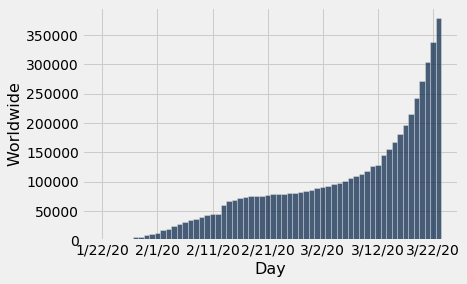

In [10]:
total_confirmed = countries_by_day.select('Day')
total_confirmed['Worldwide'] = countries_by_day.sum_rows()
print('Total confirmed', total_confirmed.last('Worldwide'))
total_confirmed.obar()

## Global confirmed cases by country - largest

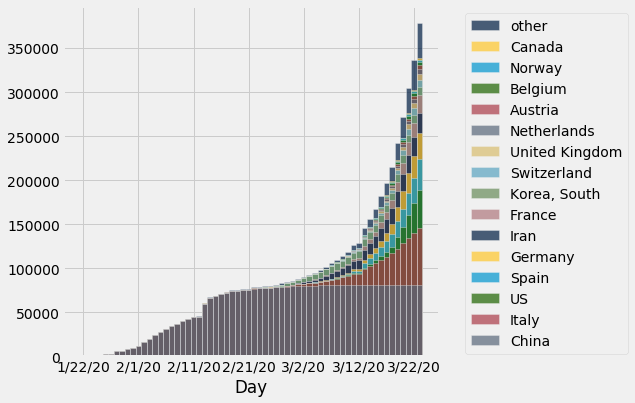

In [11]:
# Breaking this picture down by largest caseloads

countries_by_day.stackbar(15, height=6)

In [12]:
# Recent worldwide growth trend - past week
total_confirmed.trend().take[-7:]

Day,Worldwide,new,% new,rate
3/17/20,197150,15577,7.90%,1.08579
3/18/20,214909,17759,8.26%,1.09008
3/19/20,242706,27797,11.45%,1.12934
3/20/20,272164,29458,10.82%,1.12137
3/21/20,304519,32355,10.62%,1.11888
3/22/20,337089,32570,9.66%,1.10696
3/23/20,378547,41458,10.95%,1.12299


## Global picture sans China

The global growth rate above is somewhat optimistic, since the growth across the world is amortized over the substantial, but flat, cases in China, now mostly resolved.  Removing that we see a more accurate picture of the trends

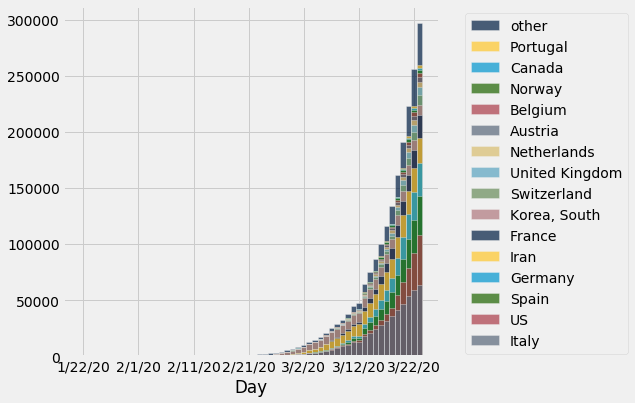

In [13]:
# Taking China out of the picture
sans_china_by_day = countries_by_day.drop('China')
sans_china_by_day.stackbar(15, height=6)

In [14]:
sans_china_confirmed = sans_china_by_day.select('Day')
sans_china_confirmed['Worldwide sans China'] = sans_china_by_day.sum_rows()
sans_china_confirmed.trend().take[-15:].show()

Day,Worldwide sans China,new,% new,rate
3/9/20,32711,3729,11.40%,1.12867
3/10/20,37715,5004,13.27%,1.15298
3/11/20,44954,7239,16.10%,1.19194
3/12/20,47421,2467,5.20%,1.05488
3/13/20,64264,16843,26.21%,1.35518
3/14/20,75127,10863,14.46%,1.16904
3/15/20,86451,11324,13.10%,1.15073
3/16/20,100540,14089,14.01%,1.16297
3/17/20,116092,15552,13.40%,1.15468
3/18/20,133807,17715,13.24%,1.15259


## Projecting global trends into the near future

The following indicates confirmed cases for the two weeks ahead.

In [15]:
project_trend(total_confirmed.trend().take[-10:], 14).show()

Day,Worldwide,new,% new,rate
3/14/20,156104,10895,0.0697932,1.07503
3/15/20,167454,11350,0.0677798,1.07271
3/16/20,181573,14119,0.0777594,1.08432
3/17/20,197150,15577,0.0790109,1.08579
3/18/20,214909,17759,0.082635,1.09008
3/19/20,242706,27797,0.11453,1.12934
3/20/20,272164,29458,0.108236,1.12137
3/21/20,304519,32355,0.10625,1.11888
3/22/20,337089,32570,0.0966214,1.10696
3/23/20,378547,41458,0.109519,1.12299


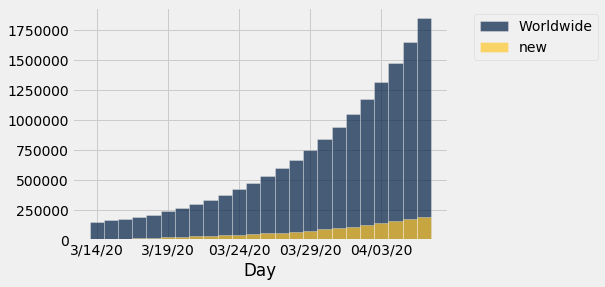

In [16]:
project_trend(total_confirmed.trend().take[-10:], 14).select(range(3)).bar('Day')

Assuming China stays flat and using the growth rate of the rest of the world, we get a more concerning picture.

In [17]:
project_trend(sans_china_confirmed.trend().take[-10:], 14).show()

Day,Worldwide sans China,new,% new,rate
3/14/20,75127,10863,0.144595,1.16904
3/15/20,86451,11324,0.130987,1.15073
3/16/20,100540,14089,0.140133,1.16297
3/17/20,116092,15552,0.133963,1.15468
3/18/20,133807,17715,0.132392,1.15259
3/19/20,161550,27743,0.17173,1.20734
3/20/20,190914,29364,0.153807,1.18176
3/21/20,223214,32300,0.144704,1.16919
3/22/20,255654,32440,0.12689,1.14533
3/23/20,297049,41395,0.139354,1.16192


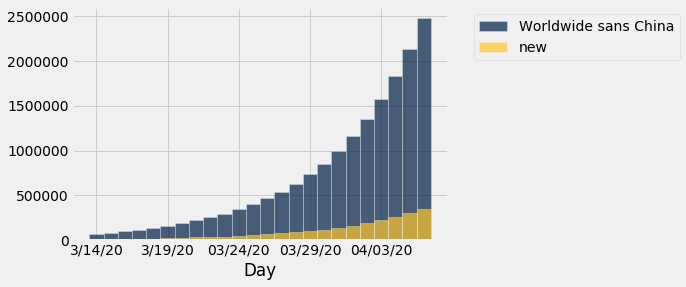

In [18]:
project_trend(sans_china_confirmed.trend().take[-10:], 14).select(range(3)).bar('Day')

# Country level trends

Recent confirmed cases on a country by country basis.

In [19]:
countries_by_day.top(15).take[-10:]

Day,China,Italy,US,Spain,Germany,Iran,France,"Korea, South",Switzerland,United Kingdom,Netherlands,Austria,Belgium,Norway,Canada
3/14/20,80977,21157,2727,6391,4585,12729,4496,8086,1359,1144,962,655,689,1090,198
3/15/20,81003,24747,3499,7798,5795,13938,4532,8162,2200,1145,1138,860,886,1221,252
3/16/20,81033,27980,4632,9942,7272,14991,6683,8236,2200,1551,1416,1018,1058,1333,415
3/17/20,81058,31506,6421,11748,9257,16169,7715,8320,2700,1960,1711,1332,1243,1463,478
3/18/20,81102,35713,7783,13910,12327,17361,9124,8413,3028,2642,2058,1646,1486,1550,657
3/19/20,81156,41035,13677,17963,15320,18407,10970,8565,4075,2716,2467,2013,1795,1746,800
3/20/20,81250,47021,19100,20410,19848,19644,12758,8652,5294,4014,3003,2388,2257,1914,943
3/21/20,81305,53578,25489,25374,22213,20610,14463,8799,6575,5067,3640,2814,2815,2118,1277
3/22/20,81435,59138,33276,28768,24873,21638,16243,8961,7474,5745,4217,3582,3401,2385,1469
3/23/20,81498,63927,43847,35136,29056,23049,20123,8961,8795,6726,4764,4474,3743,2621,2088


In [20]:
countries_by_day.top(5).trend().take[-10:]

Day,China,new China,% newChina,rate China,Italy,new Italy,% newItaly,rate Italy,US,new US,% newUS,rate US,Spain,new Spain,% newSpain,rate Spain,Germany,new Germany,% newGermany,rate Germany
3/14/20,80977,32,0.04%,1.0004,21157,3497,16.53%,1.19802,2727,548,20.10%,1.25149,6391,1159,18.13%,1.22152,4585,910,19.85%,1.24762
3/15/20,81003,26,0.03%,1.00032,24747,3590,14.51%,1.16968,3499,772,22.06%,1.28309,7798,1407,18.04%,1.22015,5795,1210,20.88%,1.2639
3/16/20,81033,30,0.04%,1.00037,27980,3233,11.55%,1.13064,4632,1133,24.46%,1.32381,9942,2144,21.57%,1.27494,7272,1477,20.31%,1.25487
3/17/20,81058,25,0.03%,1.00031,31506,3526,11.19%,1.12602,6421,1789,27.86%,1.38623,11748,1806,15.37%,1.18165,9257,1985,21.44%,1.27296
3/18/20,81102,44,0.05%,1.00054,35713,4207,11.78%,1.13353,7783,1362,17.50%,1.21212,13910,2162,15.54%,1.18403,12327,3070,24.90%,1.33164
3/19/20,81156,54,0.07%,1.00067,41035,5322,12.97%,1.14902,13677,5894,43.09%,1.75729,17963,4053,22.56%,1.29137,15320,2993,19.54%,1.2428
3/20/20,81250,94,0.12%,1.00116,47021,5986,12.73%,1.14588,19100,5423,28.39%,1.39651,20410,2447,11.99%,1.13622,19848,4528,22.81%,1.29556
3/21/20,81305,55,0.07%,1.00068,53578,6557,12.24%,1.13945,25489,6389,25.07%,1.3345,25374,4964,19.56%,1.24321,22213,2365,10.65%,1.11916
3/22/20,81435,130,0.16%,1.0016,59138,5560,9.40%,1.10377,33276,7787,23.40%,1.3055,28768,3394,11.80%,1.13376,24873,2660,10.69%,1.11975
3/23/20,81498,63,0.08%,1.00077,63927,4789,7.49%,1.08098,43847,10571,24.11%,1.31768,35136,6368,18.12%,1.22136,29056,4183,14.40%,1.16817


### Confirmed cases in one country

In [21]:
w = widgets.Dropdown(
    options=countries_by_day.categories,
    value='US',
    # rows=10,
    description='Country:',
    disabled=False
)
w

Dropdown(description='Country:', index=157, options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',…

In [22]:
country = w.value

In [23]:
country_trend = countries_by_day.extract(country).trend()
country_trend.following('3/11/20').show()

Day,US,new,% new,rate
3/11/20,1281,322,0.251366,1.33577
3/12/20,1663,382,0.229705,1.2982
3/13/20,2179,516,0.236806,1.31028
3/14/20,2727,548,0.200953,1.25149
3/15/20,3499,772,0.220634,1.28309
3/16/20,4632,1133,0.244603,1.32381
3/17/20,6421,1789,0.278617,1.38623
3/18/20,7783,1362,0.174997,1.21212
3/19/20,13677,5894,0.430942,1.75729
3/20/20,19100,5423,0.283927,1.39651


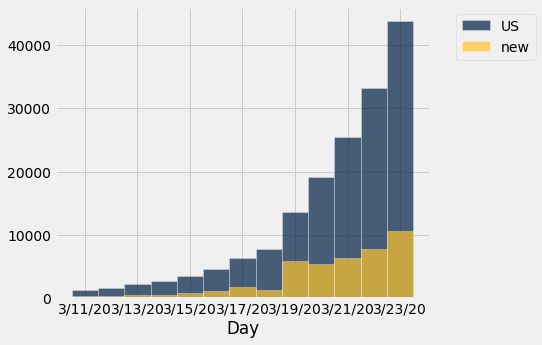

In [24]:
recent = country_trend.following('3/11/20')
recent.extract([country, 'new']).bar('Day', height=5)

In [25]:
projection = project_trend(recent, 10)
projection.show()

Day,US,new,% new,rate
3/11/20,1281,322,0.251366,1.33577
3/12/20,1663,382,0.229705,1.2982
3/13/20,2179,516,0.236806,1.31028
3/14/20,2727,548,0.200953,1.25149
3/15/20,3499,772,0.220634,1.28309
3/16/20,4632,1133,0.244603,1.32381
3/17/20,6421,1789,0.278617,1.38623
3/18/20,7783,1362,0.174997,1.21212
3/19/20,13677,5894,0.430942,1.75729
3/20/20,19100,5423,0.283927,1.39651


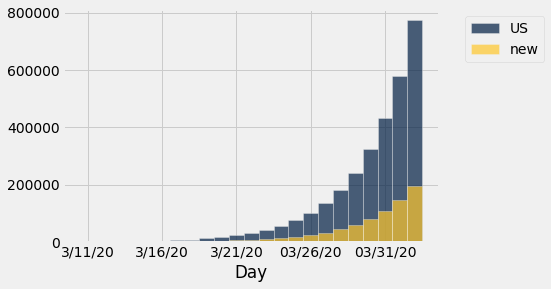

In [26]:
projection.extract([country, 'new']).bar('Day')